In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import compute_class_weight
%tensorflow_version 2.8
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras 
from tensorflow.keras import layers 
from sklearn.metrics import f1_score
from keras_preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import albumentations as A
import cv2
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D, Rescaling
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras import backend as K

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
#!pip install tensorflow==2.8
#!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
#!pip install cudnn
#! nvcc --version
#!nvidia-smi

#!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
print(tf.__version__)
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

2.8.2


Import pra passar os arquivos do datset via drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Folds.csv')
img_dir = '/content/drive/MyDrive/'
class_names = ['benign', 'malignant']
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  myModel_best.h5	myModel.h5  sample_data


In [ ]:
data = data.rename(columns={'filename':'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])
data.head(3)

,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-003.png


Carregando o Dataset

  

In [ ]:
from os import path
image_size = (224,224)
batch_size = 32

path = ['/content/drive/MyDrive/Breast40x','/content/drive/MyDrive/Breast100x',
         '/content/drive/MyDrive/Breast200x','/content/drive/MyDrive/Breast400x'
]
path_teste = ['/content/drive/MyDrive/Testes/teste40','/content/drive/MyDrive/Testes/teste100',
              '/content/drive/MyDrive/Testes/teste200','/content/drive/MyDrive/Testes/teste400']

i = 3

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path[i],
    # color_mode = 'grayscale',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size = image_size,
    batch_size = batch_size,
    label_mode = 'binary',
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path[i],
    # color_mode = 'grayscale',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'binary',
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_teste[i],
    seed=1337,
    # color_mode = 'grayscale',
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'binary',
)


Found 1740 files belonging to 2 classes.
Using 1392 files for training.
Found 1740 files belonging to 2 classes.
Using 348 files for validation.
Found 80 files belonging to 2 classes.


In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(9):
#         print(images.shape)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(int(labels[i]))
#         plt.axis("off")

Plotando as imagens

In [ ]:
data_augmentation = keras.Sequential(
   [
      layers.RandomFlip("horizontal",True),
      layers.RandomRotation(0.1),
      layers.RandomTranslation(0.2,0.2),
      layers.RandomContrast(factor = [0,1]),
      layers.RandomCrop(224,224,seed = None),
   ]
)


In [ ]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#     print(images.shape)
#     for i in range(9):
#       augmented_images = data_augmentation(images,training = True)
#       ax = plt.subplot(3, 3, i + 1)
#       plt.imshow(augmented_images[0].numpy().astype("uint8"))
#       plt.axis("off")
      


using the data_augmentation preprocessor:

Performance


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

BUILNDING A MODEL

In [ ]:
# def make_model(input_shape, num_classes):
#     inputs = keras.Input(shape=input_shape)
#     # Image augmentation block
#     x = data_augmentation(inputs)

#     # Entry block
#     x = layers.Rescaling(1.0 / 255)(x)
#     x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation(tf.keras.layers.LeakyReLU())(x)

#     x = layers.Conv2D(64, 3, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation(tf.keras.layers.LeakyReLU())(x)

#     previous_block_activation = x  # Set aside residual

#     for size in [128, 256, 512, 728]:
#         x = layers.Activation(tf.keras.layers.LeakyReLU())(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation(tf.keras.layers.LeakyReLU())(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(size, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     x = layers.SeparableConv2D(1024, 3, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation(tf.keras.layers.LeakyReLU())(x)

#     x = layers.GlobalAveragePooling2D()(x)
#     if num_classes == 2:
#         activation = "sigmoid"
#         units = 1
#     else:
#         activation = "softmax"
#         units = num_classes

#     x = layers.Dropout(0.5)(x)
#     outputs = layers.Dense(units, activation=activation)(x)
#     return keras.Model(inputs, outputs)


# model = make_model(input_shape=image_size + (3,), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)

BUILDING RESNET50


In [ ]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation(tf.keras.layers.LeakyReLU())(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation(tf.keras.layers.LeakyReLU())(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation(tf.keras.layers.LeakyReLU())(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation(tf.keras.layers.LeakyReLU())(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation(tf.keras.layers.LeakyReLU())(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation(tf.keras.layers.LeakyReLU())(X)

    return X

def ResNet50(input_shape=(224,224,3)):

    X_input = Input(input_shape)
    X_input = Rescaling(1./255)(X_input)
    X_input = data_augmentation(X_input)
    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation(tf.keras.layers.LeakyReLU())(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model
base_model = ResNet50(input_shape=(224, 224,3))
headModel = base_model.output
headModel = Flatten()(headModel)
headModel= Dense(256, activation=tf.keras.layers.LeakyReLU(), name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel= Dense(128, activation=tf.keras.layers.LeakyReLU(), name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)
model = Model(inputs=base_model.input, outputs=headModel)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_6[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d_2[1][0]']       
                                )                                                           

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
weight_for_0 = 0.1
weight_for_1 = 10

# class_weight = {0:weight_for_0,1:weight_for_1}
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy",f1_m,precision_m, recall_m],
)

es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "myModel_best.h5", save_best_only=True
)

H = model.fit(train_ds,validation_data=val_ds,epochs = epochs,verbose=1,callbacks=[checkpoint_cb,es])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


48/48 [==============================] - 359s 6s/step - loss: 0.6229 - accuracy: 0.7343 - f1_m: 0.8015 - precision_m: 0.7996 - recall_m: 0.8608 - val_loss: 0.6155 - val_accuracy: 0.6841 - val_f1_m: 0.8091 - val_precision_m: 0.6840 - val_recall_m: 1.0000
Epoch 2/20
48/48 [==============================] - 26s 493ms/step - loss: 0.3350 - accuracy: 0.8564 - f1_m: 0.8960 - precision_m: 0.8838 - recall_m: 0.9200 - val_loss: 0.6202 - val_accuracy: 0.6841 - val_f1_m: 0.8085 - val_precision_m: 0.6841 - val_recall_m: 1.0000
Epoch 3/20
48/48 [==============================] - 26s 480ms/step - loss: 0.2299 - accuracy: 0.9047 - f1_m: 0.9315 - precision_m: 0.9212 - recall_m: 0.9527 - val_loss: 0.7723 - val_accuracy: 0.6841 - val_f1_m: 0.8104 - val_precision_m: 0.6842 - val_recall_m: 1.0000
Epoch 4/20
48/48 [==============================] - 26s 484ms/step - loss: 0.1572 - accuracy: 0.9386 - f1_m: 0.9561 - precision_m: 0.9487 - recall_m: 0.9717 - val_loss: 0.7308 - val_accuracy: 0.6841 - val_f1_m: 0

# Nova seção

In [ ]:
model.save("myModel.h5")

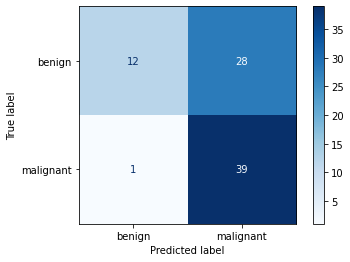

In [ ]:
y_true = []
y_pred = []
model = load_model("myModel_best.h5", custom_objects={'f1_m':f1_m,'precision_m':precision_m,'recall_m':recall_m})
for x,y in test_ds:
  #plt.imshow(x[0].numpy().astype("uint8"))
  #plt.show()
  #y= tf.argmax(y,axis=1)
  y_true.append(y)
  #print(model.predict(x))
  
  
  y_pred.append(model.predict(x))
  
y_pred = tf.concat(y_pred, axis=0).numpy()
y_true = tf.concat(y_true, axis=0)
y_pred = y_pred[:,0]
y_pred[y_pred<0.5] = 0
y_pred[y_pred>0.5] = 1

cm_traces = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_traces, display_labels= class_names) 
disp.plot(cmap=plt.cm.Blues)
plt.show()

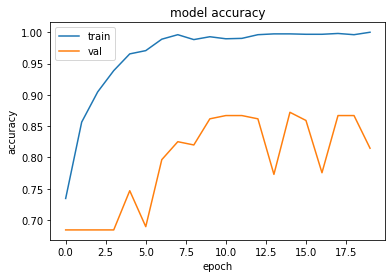

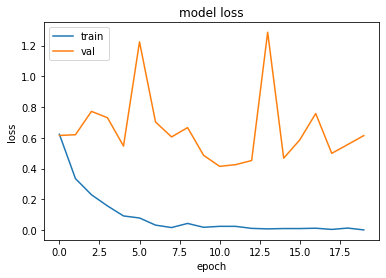

In [ ]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred,digits = 4))



# + Operações de AUGMENTATION 
# Balanceamento das classes 
# F1-SCORE
# MUDANÇA NOS OTMIZADORES / VALORES 
# Aplicar pre processamento 
# TESTAR RESNET 
# REPETIR TESTES 



              precision    recall  f1-score   support

         0.0     0.9231    0.3000    0.4528        40
         1.0     0.5821    0.9750    0.7290        40

    accuracy                         0.6375        80
   macro avg     0.7526    0.6375    0.5909        80
weighted avg     0.7526    0.6375    0.5909        80

